In [42]:
import numpy as np
import gymnasium as gym
import os
import copy
import keyboard
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from easydict import EasyDict as edict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print(device)
torch.set_default_dtype(torch.float64)

cuda


In [43]:
#Hyperparameters
hyper= edict()

hyper.batch_size = 10000 #Size of mini batch
hyper.gamma =0.99 #Discount
hyper.learning_rate = 0.001 #Learning Rate

hyper.total_time = 150000 #Total time steps
hyper.buffer = 30000 #Size of replay buffer
hyper.sync = 40  #Synchronization timesteps for target and q network
hyper.train_freq= 10 #Frequency of training after replay buffer filled

hyper.e_start = 1 #Starting epsilon
hyper.e_end= 0.1 #Ending epsilon
hyper.exp_fraction= 0.9 #% of total timesteps for decaying epsilon

hyper.log= 1000 #Frequency of return logging
hyper.num_envs=3 #Number of parallel environments

In [44]:
class Agent(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.q_net = nn.Sequential(
            nn.Linear(np.array(env.single_observation_space.shape).prod(), 40), nn.LeakyReLU(0.1),
            nn.Linear(40, 64), nn.LeakyReLU(0.1), 
            nn.Linear(64, env.single_action_space.n), nn.LeakyReLU(0.1))

        self.target_net = copy.deepcopy(self.q_net)  

    def sync_net(self):
        self.target_net.load_state_dict(self.q_net.state_dict())

    def target_vals(self, obs):
        return self.target_net(obs)
    
    def q_vals(self, obs):
        return self.q_net(obs)       

In [45]:
class ReplayBuffer():
    def __init__(self, buffer_size, obs_space, act_space, device, n_env):
        self.buffer_size = buffer_size
        self.n_env= n_env
        self.device= device
        
        self.obs = np.empty((0, obs_space))
        self.next_obs = np.empty((0, obs_space))
        self.act = np.empty(0)
        self.rew = np.empty(0)
        self.dones = np.empty(0, dtype= bool)

    def to_numpy(self, data):
        if isinstance(data, torch.Tensor):
            return data.cpu().numpy()
        return data 

    def add(self, obs, next_obs, act, rew, dones):
        #Convert to Numpy and send to CPU
        obs = self.to_numpy(obs)
        next_obs = self.to_numpy(next_obs)
        act = self.to_numpy(act)
        rew = self.to_numpy(rew)
        done = self.to_numpy(dones)
        
        if len(self.obs)>= self.buffer_size:
            self.obs= self.obs[self.n_env:]
            self.next_obs= self.next_obs[self.n_env:]
            self.act= self.act[self.n_env:]
            self.rew= self.rew[self.n_env:]
            self.dones= self.dones[self.n_env:]
        
        self.obs= np.append(self.obs, obs, axis=0)
        self.next_obs= np.append(self.next_obs, next_obs, axis=0)
        self.act= np.append(self.act, act, axis=0)
        self.rew= np.append(self.rew, rew, axis=0)
        self.dones= np.append(self.dones, dones, axis=0)
        
    def show(self):        
        print("Observations: ", self.obs)
        print("Next observations: ", self.next_obs)
        print("Actions: ", self.act)
        print("Rewards: ", self.rew)
        print("Dones: ", self.dones)

    def sample(self, batch_size):
        index= np.random.choice(len(self.obs), batch_size, replace = False)
        #print("Index: ", index)
        data= edict
        data.obs = torch.from_numpy(self.obs[index]).to(self.device)
        data.next_obs= torch.from_numpy(self.next_obs[index]).to(self.device)
        data.act= torch.from_numpy(self.act[index]).to(torch.int64).to(self.device)
        data.rew= torch.from_numpy(self.rew[index]).to(torch.int64).to(self.device)
        data.dones= torch.from_numpy(self.dones[index]).to(self.device)
        return data
        

In [46]:
#Epsilon annealing
def ret_e(start_e: float, end_e: float, duration: int, t: int):
    slope = (end_e - start_e) / duration
    return max(slope * t + start_e, end_e) 

In [47]:
#TD target calculation
def calc_TD_target(data, agent): 
    with torch.no_grad():
        target_max, _ = agent.target_vals(data.next_obs).max(dim=1)
        td_target = data.rew.flatten() + hyper.gamma * target_max * (1 - data.dones.flatten().float())
    return td_target

In [48]:
#TD target calculation for Double Deep Q-learning
def calc_TD_target_DDQN(data, agent):
    with torch.no_grad():                                         
        q_net_vals= agent.q_vals(data.next_obs)
        act= torch.argmax(q_net_vals, dim=1)
        vals = agent.target_vals(data.next_obs)
        target_max= vals[torch.arange(vals.size(0)) , act]
        td_target = data.rew.flatten() + hyper.gamma * target_max * (1 - data.dones.flatten().float())

    return td_target

In [49]:
#e-greedy policy calculation
def e_greedy_policy(agent, obs, epsilon, env): 
    if random.random() < epsilon:
        action = np.array([env.single_action_space.sample() for i in range(hyper.num_envs)])
    else:
        q_values = agent.q_vals(torch.Tensor(obs).to(device))  
        action = torch.argmax(q_values, dim=1).cpu().numpy()       
    return action

10000 episode return 9.0
20000 episode return 140.0
30000 episode return 274.0
40000 episode return 305.0
50000 episode return 390.0
60000 episode return 229.0
70000 episode return 206.0
80000 episode return 254.0
90000 episode return 274.0
100000 episode return 10000.0
110000 episode return 137.0
120000 episode return 10000.0
130000 episode return 10000.0
140000 episode return 10000.0
150000 episode return 10000.0


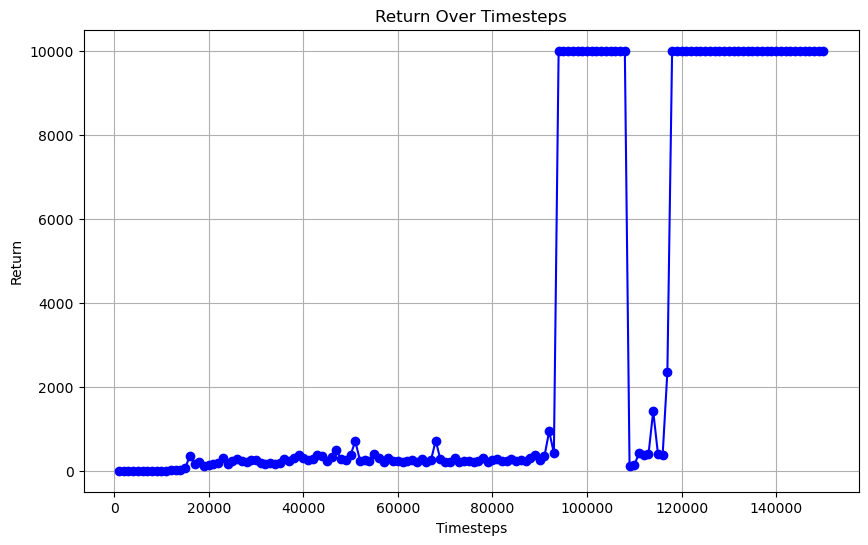

In [50]:
#Parallelized training environments
env = gym.make_vec("CartPole-v1", num_envs = hyper.num_envs, vectorization_mode="async")

#Test environment
test_env= gym.make_vec("CartPole-v1", num_envs = 1, vectorization_mode="async")

#Define the replay buffer
act_dim=1
rb= ReplayBuffer(hyper.buffer, env.single_observation_space.shape[0], act_dim, device, hyper.num_envs)

#Agent class and optimizer
agent = Agent(env).to(device)
optimizer = optim.Adam(agent.q_net.parameters(), lr=hyper.learning_rate)

#Logging rewards
return_log= np.empty((0,2))


obs, _= env.reset()
for i in range(hyper.total_time):
    epsilon = ret_e(hyper.e_start, hyper.e_end, hyper.exp_fraction * hyper.total_time, i)
    action = e_greedy_policy(agent, obs , epsilon, env)
    next_obs, reward, done, _, infos=  env.step(action)
    
    rb.add(obs, next_obs, action, reward, done)
    obs=next_obs

    if i*hyper.num_envs >= hyper.buffer:
        if i % hyper.train_freq==0:
            data= rb.sample(hyper.batch_size)
            old_val = agent.q_vals(data.obs).gather(1, data.act.unsqueeze(-1)).squeeze(-1)
            td_target = calc_TD_target_DDQN(data,agent)
            #td_target = calc_TD_target(data, agent)
            loss = (td_target - old_val).square().mean() 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    if i % hyper.sync == 0:
            agent.sync_net()

    #For performance logging only
    if (i+1)%hyper.log==0:
        ret=0
        t_obs, _= test_env.reset()
        t_done=False
        
        while  (t_done==False) and (ret < 10000):
            q_max= agent.q_vals(torch.Tensor(t_obs).to(device))  
            t_action = torch.argmax(q_max, dim=1).cpu().numpy() 
            t_next_obs, t_reward, t_done, _, t_infos=  test_env.step(t_action) 
            t_obs= t_next_obs
            ret += t_reward
        
        ret=ret.item()    
        return_log = np.append(return_log, np.array([[i+1, ret]]), axis=0)
        if (i+1)%10000==0:
            print(f"{i+1} episode return {ret}")
            
test_env.close()
env.close()   

# Plot the return over time
plt.figure(figsize=(10, 6))
plt.plot(return_log[:, 0], return_log[:, 1], marker='o', linestyle='-', color='b')
plt.xlabel('Timesteps')
plt.ylabel('Return')
plt.title('Return Over Timesteps')
plt.grid(True)
plt.show()

In [51]:
#Run the trained policy
test_env= gym.make_vec("CartPole-v1", num_envs = 1, vectorization_mode="async", render_mode='human')
t_obs, _= test_env.reset()
t_done=False

while not t_done:
    test_env.render()
    if keyboard.is_pressed('q'):
        print("Exiting...")
        break
    q_max= agent.q_vals(torch.Tensor(t_obs).to(device))  
    t_action = torch.argmax(q_max, dim=1).cpu().numpy() 
    t_next_obs, t_reward, t_done, _, t_infos=  test_env.step(t_action) 
    t_obs= t_next_obs
test_env.close()

Exiting...
